In [3]:
!pip install scikit-plot

In [4]:
!pip install pandas

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [6]:
from google.colab import files
uploaded = files.upload()
df = uploaded
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'
df.head()

Saving air_dataset.csv to air_dataset.csv


,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [7]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    df = df.reindex(dfX.index)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [8]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [9]:
res = prepare_dataset(df, class_name)
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [11]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# Base

In [12]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

In [13]:
def build_model1():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
    return model

In [ ]:
model1 = build_model1()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5426 - accuracy: 0.7210 - precision: 0.5628 - recall: 0.1293
Epoch 2/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5231 - accuracy: 0.7315 - precision: 0.6129 - recall: 0.1767
Epoch 3/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5068 - accuracy: 0.7361 - precision: 0.6178 - recall: 0.2135
Epoch 4/50
749/749 [==============================] - 1s 1ms/step - loss: 0.4965 - accuracy: 0.7424 - precision: 0.6256 - recall: 0.2572
Epoch 5/50
749/749 [==============================] - 1s 1ms/step - loss: 0.4877 - accuracy: 0.7476 - precision: 0.6328 - recall: 0.2893
Epoch 6/50
749/749 [==============================] - 1s 1ms/step - loss: 0.4808 - accuracy: 0.7536 - precision: 0.6466 - recall: 0.3140
Epoch 7/50
749/749 [==============================] - 1s 1ms/step - loss: 0.4742 - accuracy: 0.7548 - precision: 0.6468 - recall: 0.3228
Epoch 8/50
749/749 [=====================

In [ ]:
model2 = build_model1()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
150/150 [==============================] - 0s 1ms/step - loss: 0.5473 - accuracy: 0.7230
Epoch 2/50
150/150 [==============================] - 0s 1ms/step - loss: 0.5302 - accuracy: 0.7263
Epoch 3/50
150/150 [==============================] - 0s 1ms/step - loss: 0.5219 - accuracy: 0.7284
Epoch 4/50
150/150 [==============================] - 0s 1ms/step - loss: 0.5140 - accuracy: 0.7320
Epoch 5/50
150/150 [==============================] - 0s 1ms/step - loss: 0.5040 - accuracy: 0.7377
Epoch 6/50
150/150 [==============================] - 0s 2ms/step - loss: 0.4991 - accuracy: 0.7397
Epoch 7/50
150/150 [==============================] - 0s 1ms/step - loss: 0.4903 - accuracy: 0.7439
Epoch 8/50
150/150 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.7491
Epoch 9/50
150/150 [==============================] - 0s 1ms/step - loss: 0.4788 - accuracy: 0.7524
Epoch 10/50
150/150 [==============================] - 0s 1ms/step - loss: 0.4725 - accuracy: 0.7606

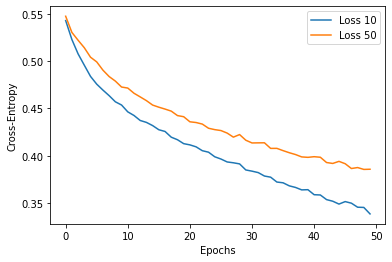

In [ ]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

#meglio batch piccoli

In [ ]:
test_loss_1, test_acc_1,pre,rec = model1.evaluate(X_test, y_test)

print('MODEL 1: Loss %f, Accuracy %f Precision %f, Recall: %f' % (test_loss_1, test_acc_1,pre,rec))

59/59 [==============================] - 0s 970us/step - loss: 0.4783 - accuracy: 0.7821 - precision: 0.6650 - recall: 0.4870
MODEL 1: Loss 0.478290, Accuracy 0.782051 Precision 0.664975, Recall: 0.486989


In [ ]:
y_pred = model1.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7126068376068376
F1-score 0.4160948222083593
Precision 0.0
Recall 0.0
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1334
           1       0.00      0.00      0.00       538

    accuracy                           0.71      1872
   macro avg       0.36      0.50      0.42      1872
weighted avg       0.51      0.71      0.59      1872



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1334,    0],
       [ 538,    0]])

In [34]:
model11 = build_model1()

history11 = model11.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=2).history

Epoch 1/10
3743/3743 [==============================] - 6s 2ms/step - loss: 0.5429 - accuracy: 0.7221 - precision_8: 0.5692 - recall_8: 0.1340 - val_loss: 0.5522 - val_accuracy: 0.7126 - val_precision_8: 0.5000 - val_recall_8: 0.3067
Epoch 2/10
3743/3743 [==============================] - 6s 2ms/step - loss: 0.5177 - accuracy: 0.7315 - precision_8: 0.6094 - recall_8: 0.1814 - val_loss: 0.5227 - val_accuracy: 0.7222 - val_precision_8: 0.5662 - val_recall_8: 0.1431
Epoch 3/10
3743/3743 [==============================] - 6s 2ms/step - loss: 0.5015 - accuracy: 0.7396 - precision_8: 0.6233 - recall_8: 0.2363 - val_loss: 0.5105 - val_accuracy: 0.7415 - val_precision_8: 0.6378 - val_recall_8: 0.2323
Epoch 4/10
3743/3743 [==============================] - 6s 2ms/step - loss: 0.4874 - accuracy: 0.7467 - precision_8: 0.6340 - recall_8: 0.2795 - val_loss: 0.5087 - val_accuracy: 0.7329 - val_precision_8: 0.5720 - val_recall_8: 0.2807
Epoch 5/10
3743/3743 [==============================] - 6s 2ms/s

In [35]:
test_loss_11, test_acc_11,a,b = model11.evaluate(X_test, y_test)


print('Loss %f, Accuracy %f' % (test_loss_11, test_acc_11))

59/59 [==============================] - 0s 1ms/step - loss: 0.4977 - accuracy: 0.7463 - precision_8: 0.6207 - recall_8: 0.3011
Loss 0.497730, Accuracy 0.746261


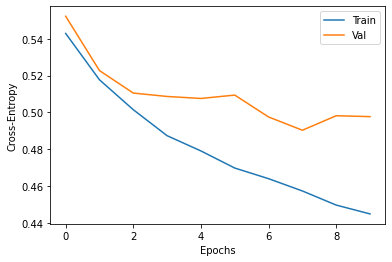

In [36]:
plt.plot(history11['loss'], label='Train')
plt.plot(history11['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

# Uno

In [ ]:
def build_model3():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='tanh'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model3 = build_model3()

history3 = model3.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6956 - accuracy: 0.6870
Epoch 2/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5860 - accuracy: 0.7126
Epoch 3/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5590 - accuracy: 0.7126
Epoch 4/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6080 - accuracy: 0.6854
Epoch 5/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5451 - accuracy: 0.7264
Epoch 6/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5347 - accuracy: 0.7197
Epoch 7/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5146 - accuracy: 0.7361
Epoch 8/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5167 - accuracy: 0.7371
Epoch 9/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5244 - accuracy: 0.7371
Epoch 10/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5011 - accuracy: 0.7507

In [ ]:
def build_model4():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model4 = build_model4()

history4 = model4.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5736 - accuracy: 0.7009
Epoch 2/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5527 - accuracy: 0.7173
Epoch 3/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5430 - accuracy: 0.7232
Epoch 4/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5320 - accuracy: 0.7244
Epoch 5/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5233 - accuracy: 0.7273
Epoch 6/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5149 - accuracy: 0.7304
Epoch 7/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5081 - accuracy: 0.7315
Epoch 8/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5010 - accuracy: 0.7407
Epoch 9/50
749/749 [==============================] - 1s 1ms/step - loss: 0.4969 - accuracy: 0.7409
Epoch 10/50
749/749 [==============================] - 2s 2ms/step - loss: 0.4889 - accuracy: 0.7482

In [ ]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('MODEL 1: Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('MODEL 2: Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('MODEL 3: Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('MODEL 4: Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

59/59 [==============================] - 0s 1ms/step - loss: 0.4930 - accuracy: 0.7585
MODEL 1: Loss 0.468145, Accuracy 0.780449
MODEL 2: Loss 0.562466, Accuracy 0.740385
MODEL 3: Loss 0.584403, Accuracy 0.766026
MODEL 4: Loss 0.492960, Accuracy 0.758547


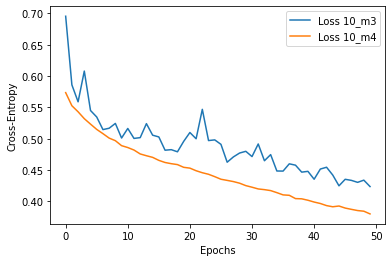

In [ ]:
plt.plot(history3['loss'], label='Loss 10_m3')
plt.plot(history4['loss'], label='Loss 10_m4')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()


# Due

In [ ]:
def build_model5():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model5 = build_model5()

history5 = model5.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
749/749 [==============================] - 1s 2ms/step - loss: 0.5512 - accuracy: 0.7162
Epoch 2/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5250 - accuracy: 0.7253
Epoch 3/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5073 - accuracy: 0.7324
Epoch 4/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4961 - accuracy: 0.7460
Epoch 5/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4830 - accuracy: 0.7479
Epoch 6/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4742 - accuracy: 0.7582
Epoch 7/50
749/749 [==============================] - 1s 1ms/step - loss: 0.4687 - accuracy: 0.7579
Epoch 8/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4597 - accuracy: 0.7653
Epoch 9/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4511 - accuracy: 0.7780
Epoch 10/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4465 - accuracy: 0.7773

In [ ]:
def build_model6():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model6 = build_model6()

history6 = model6.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5677 - accuracy: 0.7136
Epoch 2/50
749/749 [==============================] - 1s 2ms/step - loss: 0.5410 - accuracy: 0.7218
Epoch 3/50
749/749 [==============================] - 1s 2ms/step - loss: 0.5231 - accuracy: 0.7255
Epoch 4/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5147 - accuracy: 0.7341
Epoch 5/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5025 - accuracy: 0.7371
Epoch 6/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4924 - accuracy: 0.7451
Epoch 7/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4855 - accuracy: 0.7464
Epoch 8/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4788 - accuracy: 0.7563
Epoch 9/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4706 - accuracy: 0.7599
Epoch 10/50
749/749 [==============================] - 1s 2ms/step - loss: 0.4662 - accuracy: 0.7650

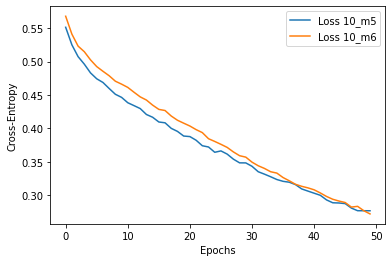

In [ ]:
plt.plot(history5['loss'], label='Loss 10_m5')
plt.plot(history6['loss'], label='Loss 10_m6')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()


In [ ]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)
test_loss_5, test_acc_5 = model5.evaluate(X_test, y_test)
test_loss_6, test_acc_6 = model4.evaluate(X_test, y_test)

print('MODEL 1: Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('MODEL 2: Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('MODEL 3: Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('MODEL 4: Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))
print('MODEL 5: Loss %f, Accuracy %f' % (test_loss_5, test_acc_5))
print('MODEL 6: Loss %f, Accuracy %f' % (test_loss_6, test_acc_6))

59/59 [==============================] - 0s 1ms/step - loss: 0.4930 - accuracy: 0.7585
MODEL 1: Loss 0.468145, Accuracy 0.780449
MODEL 2: Loss 0.562466, Accuracy 0.740385
MODEL 3: Loss 0.584403, Accuracy 0.766026
MODEL 4: Loss 0.492960, Accuracy 0.758547
MODEL 5: Loss 0.499571, Accuracy 0.791132
MODEL 6: Loss 0.492960, Accuracy 0.758547


# Finale

In [ ]:
def build_model7():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model7 = build_model7()

history7 = model7.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5518 - accuracy: 0.7216
Epoch 2/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5351 - accuracy: 0.7241
Epoch 3/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5300 - accuracy: 0.7249
Epoch 4/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5247 - accuracy: 0.7272
Epoch 5/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5208 - accuracy: 0.7301
Epoch 6/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5159 - accuracy: 0.7295
Epoch 7/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5114 - accuracy: 0.7323
Epoch 8/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5079 - accuracy: 0.7329
Epoch 9/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5051 - accuracy: 0.7367
Epoch 10/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5007 - accuracy: 0.7400

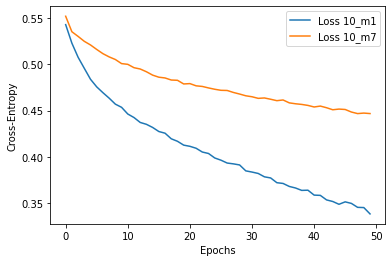

In [ ]:
plt.plot(history1['loss'], label='Loss 10_m1')
plt.plot(history7['loss'], label='Loss 10_m7')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()


In [ ]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)
test_loss_5, test_acc_5 = model5.evaluate(X_test, y_test)
test_loss_6, test_acc_6 = model6.evaluate(X_test, y_test)
test_loss_7, test_acc_7 = model7.evaluate(X_test, y_test)

print('MODEL 1: Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('MODEL 2: Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('MODEL 3: Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('MODEL 4: Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))
print('MODEL 5: Loss %f, Accuracy %f' % (test_loss_5, test_acc_5))
print('MODEL 6: Loss %f, Accuracy %f' % (test_loss_6, test_acc_6))
print('MODEL 7: Loss %f, Accuracy %f' % (test_loss_7, test_acc_7))  # single layer nn

59/59 [==============================] - 0s 1ms/step - loss: 0.4946 - accuracy: 0.7457
MODEL 1: Loss 0.468145, Accuracy 0.780449
MODEL 2: Loss 0.562466, Accuracy 0.740385
MODEL 3: Loss 0.584403, Accuracy 0.766026
MODEL 4: Loss 0.492960, Accuracy 0.758547
MODEL 5: Loss 0.499571, Accuracy 0.791132
MODEL 6: Loss 0.502838, Accuracy 0.782051
MODEL 7: Loss 0.494558, Accuracy 0.745726


In [ ]:
def build_model8():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [ ]:
model8 = build_model8()

history8 = model8.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5790 - accuracy: 0.7059
Epoch 2/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5493 - accuracy: 0.7193
Epoch 3/50
749/749 [==============================] - 1s 989us/step - loss: 0.5412 - accuracy: 0.7232
Epoch 4/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5364 - accuracy: 0.7238
Epoch 5/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5334 - accuracy: 0.7234
Epoch 6/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5303 - accuracy: 0.7261
Epoch 7/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5274 - accuracy: 0.7277
Epoch 8/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5244 - accuracy: 0.7280
Epoch 9/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5221 - accuracy: 0.7297
Epoch 10/50
749/749 [==============================] - 1s 1ms/step - loss: 0.5197 - accuracy: 0.73

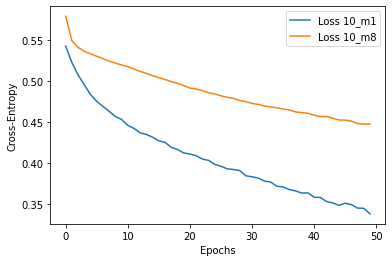

In [ ]:
plt.plot(history1['loss'], label='Loss 10_m1')
plt.plot(history8['loss'], label='Loss 10_m8')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()


In [ ]:
test_loss_8, test_acc_8 = model8.evaluate(X_test, y_test)

print('MODEL 8: Loss %f, Accuracy %f' % (test_loss_8, test_acc_8))

59/59 [==============================] - 0s 1ms/step - loss: 0.4875 - accuracy: 0.7409
MODEL 8: Loss 0.487451, Accuracy 0.740919


In [ ]:
model11 = build_model1()

history11 = model11.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=10).history

Epoch 1/30
749/749 [==============================] - 1s 2ms/step - loss: 0.5433 - accuracy: 0.7226 - val_loss: 0.5397 - val_accuracy: 0.7201
Epoch 2/30
749/749 [==============================] - 1s 1ms/step - loss: 0.5223 - accuracy: 0.7275 - val_loss: 0.5437 - val_accuracy: 0.7105
Epoch 3/30
749/749 [==============================] - 1s 1ms/step - loss: 0.5096 - accuracy: 0.7320 - val_loss: 0.5260 - val_accuracy: 0.7281
Epoch 4/30
749/749 [==============================] - 1s 1ms/step - loss: 0.4979 - accuracy: 0.7401 - val_loss: 0.5153 - val_accuracy: 0.7329
Epoch 5/30
749/749 [==============================] - 1s 1ms/step - loss: 0.4890 - accuracy: 0.7451 - val_loss: 0.5094 - val_accuracy: 0.7286
Epoch 6/30
749/749 [==============================] - 1s 1ms/step - loss: 0.4785 - accuracy: 0.7554 - val_loss: 0.5040 - val_accuracy: 0.7409
Epoch 7/30
749/749 [==============================] - 1s 1ms/step - loss: 0.4693 - accuracy: 0.7576 - val_loss: 0.4991 - val_accuracy: 0.7377
Epoch 

In [ ]:
test_loss_11, test_acc_11 = model11.evaluate(X_test, y_test)

print('MODEL 1: Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('MODEL 11: Loss %f, Accuracy %f' % (test_loss_11, test_acc_11))

59/59 [==============================] - 0s 1ms/step - loss: 0.4695 - accuracy: 0.7762
MODEL 1: Loss 0.468145, Accuracy 0.780449
MODEL 11: Loss 0.469504, Accuracy 0.776175


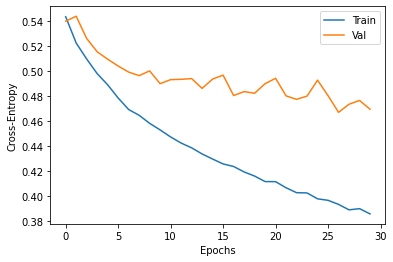

In [ ]:
plt.plot(history11['loss'], label='Train')
plt.plot(history11['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Early stopping

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

### The most relevant arguments are:

    monitor: quantity to be monitored
    patience: number of epochs with no improvement after which training will be stopped



In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model9 = build_model1()
history9 = model9.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5440 - accuracy: 0.7260 - precision_1: 0.5924 - recall_1: 0.1365 - val_loss: 0.5549 - val_accuracy: 0.7134 - val_precision_1: 0.5226 - val_recall_1: 0.1858
Epoch 2/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5259 - accuracy: 0.7315 - precision_1: 0.6031 - recall_1: 0.1809 - val_loss: 0.5439 - val_accuracy: 0.7188 - val_precision_1: 0.5484 - val_recall_1: 0.1950
Epoch 3/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5154 - accuracy: 0.7346 - precision_1: 0.6173 - recall_1: 0.1919 - val_loss: 0.5345 - val_accuracy: 0.7348 - val_precision_1: 0.6789 - val_recall_1: 0.1697
Epoch 4/100
599/599 [==============================] - 1s 1ms/step - loss: 0.5052 - accuracy: 0.7408 - precision_1: 0.6324 - recall_1: 0.2258 - val_loss: 0.5172 - val_accuracy: 0.7428 - val_precision_1: 0.7073 - val_recall_1: 0.1995
Epoch 5/100
599/599 [==============================] - 1s 1ms/step -

In [ ]:
test_loss_9, test_acc_9 = model9.evaluate(X_test, y_test)

print('MODEL 1: Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('MODEL 9: Loss %f, Accuracy %f' % (test_loss_9, test_acc_9))

# perchè con l'early stopping non migliora il risultato?

59/59 [==============================] - 0s 1ms/step - loss: 0.4947 - accuracy: 0.7601
MODEL 1: Loss 0.468145, Accuracy 0.780449
MODEL 9: Loss 0.494746, Accuracy 0.760150


# L2 Regularization

In [ ]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
599/599 [==============================] - 1s 2ms/step - loss: 1.7065 - accuracy: 0.7129 - val_loss: 1.0038 - val_accuracy: 0.7128
Epoch 2/100
599/599 [==============================] - 1s 2ms/step - loss: 0.8279 - accuracy: 0.7188 - val_loss: 0.7184 - val_accuracy: 0.7088
Epoch 3/100
599/599 [==============================] - 1s 2ms/step - loss: 0.6551 - accuracy: 0.7194 - val_loss: 0.6361 - val_accuracy: 0.7101
Epoch 4/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5968 - accuracy: 0.7196 - val_loss: 0.5970 - val_accuracy: 0.7088
Epoch 5/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5773 - accuracy: 0.7199 - val_loss: 0.5902 - val_accuracy: 0.7041
Epoch 6/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5705 - accuracy: 0.7174 - val_loss: 0.6146 - val_accuracy: 0.7021
Epoch 7/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5712 - accuracy: 0.7183 - val_loss: 0.5797 - val_accuracy: 0.7154

In [ ]:
test_loss_l2, test_acc_l2 = L2_model.evaluate(X_test, y_test)

print('MODEL L2: Loss %f, Accuracy %f' % (test_loss_l2, test_acc_l2))


59/59 [==============================] - 0s 919us/step - loss: 0.5904 - accuracy: 0.7201
MODEL L2: Loss 0.590428, Accuracy 0.720085


array([[1334,    0],
       [ 538,    0]])

In [ ]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
599/599 [==============================] - 2s 3ms/step - loss: 0.6157 - accuracy: 0.7051 - val_loss: 0.5500 - val_accuracy: 0.7081
Epoch 2/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5739 - accuracy: 0.7239 - val_loss: 0.5574 - val_accuracy: 0.6994
Epoch 3/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5709 - accuracy: 0.7239 - val_loss: 0.5870 - val_accuracy: 0.6974
Epoch 4/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5705 - accuracy: 0.7188 - val_loss: 0.5553 - val_accuracy: 0.7208
Epoch 5/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5641 - accuracy: 0.7255 - val_loss: 0.6315 - val_accuracy: 0.7174
Epoch 6/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5690 - accuracy: 0.7276 - val_loss: 0.5714 - val_accuracy: 0.7141
Epoch 7/100
599/599 [==============================] - 1s 2ms/step - loss: 0.5713 - accuracy: 0.7268 - val_loss: 0.5937 - val_accuracy: 0.6961

In [ ]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

59/59 [==============================] - 0s 980us/step - loss: 0.5233 - accuracy: 0.7516


In [ ]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.467016, Accuracy 0.770833
Loss 0.568670, Accuracy 0.720620
Loss 0.523312, Accuracy 0.751603


# Hyper-Parameter Tuning

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
    
    return model

In [ ]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [ ]:
# ci mette tanto

model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
tensorflow.python.framework.errors_impl.InvalidArgumentError:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential_14/dense_62/BiasAdd:0) = ] [[-0.246189564][-0.0751661062][-0.240400642]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]] [Op:__inference_train_function_499813]

Function call stack:
train_function


  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
tensorflow.python.framework.errors_impl.InvalidArgumentError:  assertion failed: [predictions mus

InvalidArgumentError: ignored

In [ ]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.520098 using {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 32, 'activation': 'relu'}
0.529547 (0.030586) with: {'optimizer': 'adam', 'n_layers': 3, 'h_dim': 32, 'activation': 'tanh'}
0.755568 (0.296804) with: {'optimizer': 'adagrad', 'n_layers': 3, 'h_dim': 64, 'activation': 'tanh'}
0.641325 (0.030434) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 64, 'activation': 'relu'}
0.520098 (0.004117) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 32, 'activation': 'relu'}
1.784299 (1.765627) with: {'optimizer': 'adagrad', 'n_layers': 3, 'h_dim': 32, 'activation': 'relu'}


In [ ]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

59/59 [==============================] - 0s 976us/step - loss: 0.5536 - accuracy: 0.7366
Loss 0.553638, Accuracy 0.736645
